In [3]:
'''
This is a modified notebook from the one found on my Kaggle page.
Kaggle doesn't feature the lineartrees, so I have created an ammended version, havign downloaded the data from:
https://www.kaggle.com/datasets/joshuaquahshousing/snp500-max
The updated notebook here, inlcudes a linear tree classifier as well as the other code found on my Kaggle notebook
https://www.kaggle.com/code/malhardata/whitebox-models-to-predict-sp500-daily-candles
'''

"\nThis is a modified notebook from the one found on my Kaggle page.\nKaggle doesn't feature the linear-tree package, so I have created an ammended version, havign downloaded the data from:\nhttps://www.kaggle.com/datasets/joshuaquahshousing/snp500-max\nThe updated notebook here, inlcudes a linear tree classifier as well as the other code found on my Kaggle notebook\n\n"

In [4]:
#https://www.kaggle.com/datasets/joshuaquahshousing/snp500-max
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import RidgeClassifier
from lineartree import LinearTreeClassifier
df = pd.read_csv("D:\\GSPC latest snp.csv")
print(df.head(10))
print(df.info())

         Date       Open       High        Low      Close  Adj Close  Volume
0  1927-12-30  17.660000  17.660000  17.660000  17.660000  17.660000       0
1  1928-01-03  17.760000  17.760000  17.760000  17.760000  17.760000       0
2  1928-01-04  17.719999  17.719999  17.719999  17.719999  17.719999       0
3  1928-01-05  17.549999  17.549999  17.549999  17.549999  17.549999       0
4  1928-01-06  17.660000  17.660000  17.660000  17.660000  17.660000       0
5  1928-01-09  17.500000  17.500000  17.500000  17.500000  17.500000       0
6  1928-01-10  17.370001  17.370001  17.370001  17.370001  17.370001       0
7  1928-01-11  17.350000  17.350000  17.350000  17.350000  17.350000       0
8  1928-01-12  17.469999  17.469999  17.469999  17.469999  17.469999       0
9  1928-01-13  17.580000  17.580000  17.580000  17.580000  17.580000       0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23305 entries, 0 to 23304
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  

In [5]:
#a) Some cleaning to start with
df= df[df['Volume'] != 0]
df = df.drop('Adj Close', axis = 1)
#Now Some Feature Engineering 
#b)Dates
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month_name()
df = df.drop('Date', axis = 1)
#c)Difference between close and 
#Moving Averages, Bollinger Bands (at 2 stdev), ranges and Donchian Channels(Highest High and Lowest Low)
for n in range(5,205,5):
    MA_name = "MA" + str(n)
    Range_name = "Range" + str(n)
    UpperBB_name = "UpperBB" + str(n)
    LowerBB_name = "LowerBB" + str(n)
    HH_name = "HH" + str(n)
    LL_name = "LL" + str(n)
    df[MA_name] = df['Close'].rolling(n).mean() - df['Close']
    df[UpperBB_name] = df[MA_name] + 2 * (df[MA_name].rolling(n).std())- df['Close']
    df[LowerBB_name] = df[MA_name] - 2 * (df[MA_name].rolling(n).std())- df['Close']
    df[Range_name] = df['High'].rolling(n).max() - df['Low'].rolling(n).min()- df['Close']
    df[HH_name] = df['High'].rolling(n).max()- df['Close']
    df[HH_name] = df['Low'].rolling(n).min()- df['Close']


C:\Users\PijuP\AppData\Local\Temp/ipykernel_19436/3555821432.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[LowerBB_name] = df[MA_name] - 2 * (df[MA_name].rolling(n).std())- df['Close']
C:\Users\PijuP\AppData\Local\Temp/ipykernel_19436/3555821432.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[Range_name] = df['High'].rolling(n).max() - df['Low'].rolling(n).min()- df['Close']
C:\Users\PijuP\AppData\Local\Temp/ipykernel_19436/3555821432.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually

In [6]:
#One Hot Encode ordinal catagorical variables
categorical_columns = ['Day', 'Month']
for column in categorical_columns:
    tempdf = pd.get_dummies(df[column], prefix=column)
    df = pd.merge(
        left=df,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    df = df.drop(columns=column)

In [7]:
# Drop Nan values, Create dependent variable, ie whether next bar is positive/Bull or negative/bear (1 =+ve, 0 = negative)
df= df.dropna()
df['Y'] = (df['Close'].shift(-1) - df['Open'].shift(-1)) > 0
#defragment
tempdf = df.copy()
df = tempdf
X = df.drop('Y', axis = 1)
y = df['Y']

In [8]:
#Split test and train data
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25, random_state = 0)
#Scale dependant variables
sc = StandardScaler()
xtrain = sc.fit_transform(xtrain)
xtest = sc.transform(xtest)


KeyboardInterrupt: 

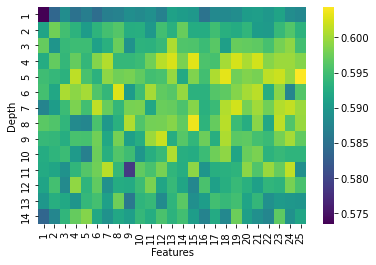

In [9]:
#Run Decision Tree classifier and Cross Validate for the best variables
Depth = []
Features =[]
Score = []
for d in range(1,15,1):
    for f in range(1,26,1):
        Depth.append(d)
        Features.append(f)
        Score.append(cross_val_score(DecisionTreeClassifier(max_depth = d, max_features = f),xtrain,ytrain,cv= KFold(n_splits=5)).mean())
cv = pd.DataFrame(list(zip(Depth, Features, Score)),columns = ['Depth', 'Features', 'Score'])
cv = cv.pivot("Depth", "Features", "Score")
sns.heatmap(cv, cmap = 'viridis')
#From this, it seems the best outcome is max features = 15, maxdepth = 6. However when looking for robust values, we want the most stable heatmap zone,not necessarily the max. So max features = 19, maxdepth = 4 is another one to try

#Run Linear Tree classifier and Cross Validate for the best variables
Depth_2 = []
Bins =[]
Score = []
for d in range(1,15,1):
    for b in range(10,35,5):
        Depth_2.append(d)
        Bins.append(b)
        Score.append(cross_val_score(LinearTreeClassifier(base_estimator=RidgeClassifier(), max_depth = d, max_bins = b),xtrain,ytrain,cv= KFold(n_splits=5)).mean())
cv = pd.DataFrame(list(zip(Depth_2, Bins, Score)),columns = ['Depth', 'Bins', 'Score'])
cv = cv.pivot("Depth", "Bins", "Score")
sns.heatmap(cv, cmap = 'colormap')
#

In [ ]:
#Fit both Decision Tree models, and a Logisitc regresion model
DT1 =DecisionTreeClassifier(max_depth = 5, max_features = 25)
DT2 =DecisionTreeClassifier(max_depth = 5, max_features = 18)
LR = LogisticRegression(random_state = 0, max_iter = 10000)
LT = LinearTreeClassifier(base_estimator=RidgeClassifier(), max_depth = 10, max_bins = 10)
DT1.fit(xtrain, ytrain)
DT2.fit(xtrain, ytrain)
LR.fit(xtrain, ytrain)
LT.fit(xtrain, ytrain)

In [ ]:
#Test the models, and return metrics
y_pred = DT1.predict(xtest)
print('Decision Tree 1')
print('accuracy score' + str(accuracy_score(ytest, y_pred)))
print(confusion_matrix(ytest, y_pred))

y_pred = DT2.predict(xtest)
print('Decision Tree 2')
print('accuracy score' + str(accuracy_score(ytest, y_pred)))
print(confusion_matrix(ytest, y_pred))

y_pred = LR.predict(xtest)
print('Linear Regression')
print('accuracy score' + str(accuracy_score(ytest, y_pred)))
print(confusion_matrix(ytest, y_pred))

y_pred = LT.predict(xtest)
print('Linear Tree')
print('accuracy score' + str(accuracy_score(ytest, y_pred)))
print(confusion_matrix(ytest, y_pred))
